<a href="https://colab.research.google.com/github/musicjae/DeepLearning/blob/main/Transfer_Learning/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Motivation  
  
처음부터 큰 데이터셋을 갖추기는 어렵기 때문에, 이미 큰 데이터셋으로 학습한 pretrained 모델을 이용한다. 이것은 (1) fine tuning: 무작위 초기화가 아닌, 이 신경망으로 초기 설정으로, (2) Fixed feature extractor: 마지막의 전연결 계층만 랜덤 weight로 설정.

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
import matplotlib.pyplot as plt

# 1 Data Load

In [7]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [20]:
train_generator.

2

# 2 Model

## 2.0 CNN

In [35]:
model2 = keras.Sequential()
model2.add(layers.Conv2D(32, kernel_size=(3,3)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(64, kernel_size=(3,3)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history2 = model2.fit_generator(generator=train_generator, epochs=3, validation_data=validation_generator,workers=4)

Epoch 1/3
22/22 [==============================] - 8s 348ms/step - loss: 1685.8613 - accuracy: 0.5317 - val_loss: 2.8964 - val_accuracy: 0.6650
Epoch 2/3
22/22 [==============================] - 7s 302ms/step - loss: 4.4992 - accuracy: 0.6037 - val_loss: 0.8871 - val_accuracy: 0.5950
Epoch 3/3
22/22 [==============================] - 7s 306ms/step - loss: 1.6971 - accuracy: 0.6066 - val_loss: 0.8034 - val_accuracy: 0.5950


#### 평가

In [67]:
print(("model accuracy : %.4f "% model2.evaluate_generator(generator= validation_generator)[1]))

model accuracy : 0.5950 


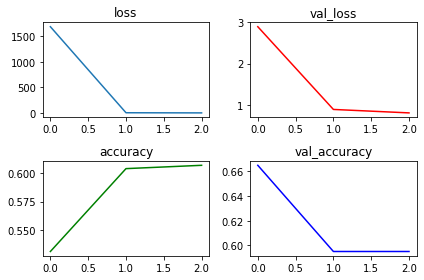

In [58]:
fig = plt.figure(figsize=(6, 4))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history2.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history2.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('accuracy') 
sub3.plot(history2.history['accuracy'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_accuracy') 
sub4.plot(history2.history['val_accuracy'],c='blue')

plt.tight_layout()
plt.show()

## 2.1 res50

In [88]:
res50 = ResNet50(include_top=False, weights='imagenet')

In [89]:
for layer in res50.layers:
    layer.trainable=False

In [91]:
x = res50.output # param num= 2048
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

prediction = layers.Dense(2, activation='softmax')(x)

model = Model(res50.input, prediction) # model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [92]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
history = model.fit_generator(generator=train_generator, epochs=3, validation_data=validation_generator, workers=16)

Epoch 1/3
22/22 [==============================] - 9s 389ms/step - loss: 0.3583 - accuracy: 0.8415 - val_loss: 0.1919 - val_accuracy: 0.9050
Epoch 2/3
22/22 [==============================] - 6s 263ms/step - loss: 0.0931 - accuracy: 0.9611 - val_loss: 0.1905 - val_accuracy: 0.9200
Epoch 3/3
22/22 [==============================] - 6s 258ms/step - loss: 0.0722 - accuracy: 0.9769 - val_loss: 0.1628 - val_accuracy: 0.9350


#### 평가

In [94]:
print("model accuracy : %.4f "% model.evaluate_generator(generator= validation_generator)[1])

model accuracy : 0.9350 


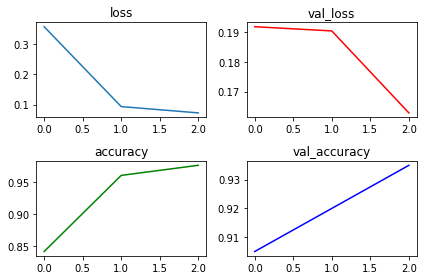

In [95]:
fig = plt.figure(figsize=(6, 4))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('accuracy') 
sub3.plot(history.history['accuracy'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_accuracy') 
sub4.plot(history.history['val_accuracy'],c='blue')

plt.tight_layout()
plt.show()

## 2.2 Inception v3

In [69]:
Inceptionv3 = InceptionV3(include_top=False,weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [80]:
for layer in Inceptionv3.layers:
    layer.trainable=False

In [81]:
x = Inceptionv3.output # param num= 2048
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

prediction = layers.Dense(2, activation='softmax')(x)

model3 = Model(Inceptionv3.input, prediction) # model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model3.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [82]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 평가


In [83]:
print("model accuracy : %.4f "% model3.evaluate_generator(generator= validation_generator)[1])

model accuracy : 0.5100 


In [85]:
history3 = model3.fit_generator(generator=train_generator, epochs=3, validation_data=validation_generator,workers=8)

Epoch 1/3
22/22 [==============================] - 7s 305ms/step - loss: 14.1439 - accuracy: 0.5576 - val_loss: 2.4602 - val_accuracy: 0.6600
Epoch 2/3
22/22 [==============================] - 6s 268ms/step - loss: 2.1421 - accuracy: 0.6182 - val_loss: 2.2365 - val_accuracy: 0.5950
Epoch 3/3
22/22 [==============================] - 6s 263ms/step - loss: 1.5328 - accuracy: 0.6427 - val_loss: 1.5590 - val_accuracy: 0.6000


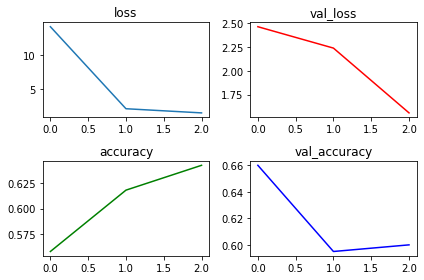

In [96]:
fig = plt.figure(figsize=(6, 4))

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('loss') # non OOP: plt.title('The function f')
sub1.plot(history3.history['loss'])

sub2 = fig.add_subplot(222) 
sub2.set_title('val_loss') 
sub2.plot(history3.history['val_loss'],c='red')

sub3 = fig.add_subplot(223) 
sub3.set_title('accuracy') 
sub3.plot(history3.history['accuracy'],c='green')

sub4 = fig.add_subplot(224) 
sub4.set_title('val_accuracy') 
sub4.plot(history3.history['val_accuracy'],c='blue')

plt.tight_layout()
plt.show()

# 3 Save, Load

In [97]:
model.save('/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/model.h5')

model.save_weights('/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/weights.h5')
with open('/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/architecture.json', 'w') as f:
        f.write(model.to_json())

In [98]:
model = load_model('/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/model.h5')

with open('/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/weights.h5')

# 4 이미지 예측

In [99]:
val_img_path = ['/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/validation/alien/0.jpg',
                '/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/validation/alien/39.jpg',
                '/content/drive/My Drive/datasets/alien_vs_predator_thumbnails/data/validation/predator/11.jpg']

img_list = [Image.open(img_path) for img_path in val_img_path]

In [116]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224)))) for img in img_list])
print(type(validation_batch))

<class 'numpy.ndarray'>


#### 모델1(resnet) 예측

In [118]:
prediction_prob = model.predict(validation_batch)
print(prediction_prob)

[[9.9966574e-01 3.3425723e-04]
 [9.9997675e-01 2.3267310e-05]
 [1.3321854e-05 9.9998665e-01]]


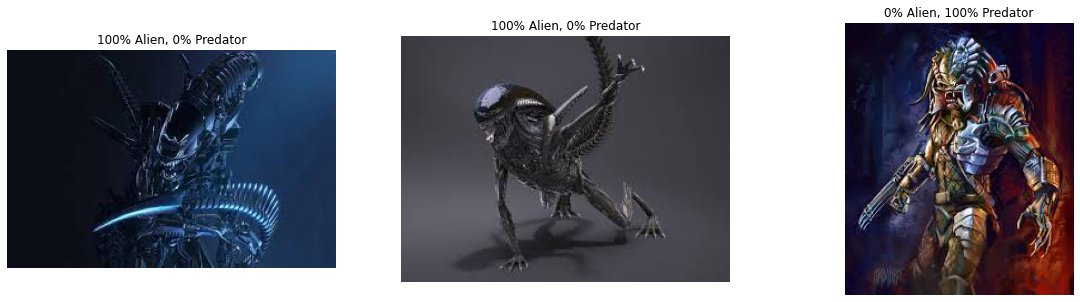

In [121]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*prediction_prob[i,0],
                                                            100*prediction_prob[i,1]))
    ax.imshow(img)

#### 모델2(CNN) 예측

In [123]:
prediction_prob2 = model2.predict(validation_batch)
print(prediction_prob2)

[[0.5163638  0.48363614]
 [0.5229894  0.4770106 ]
 [0.48521826 0.5147818 ]]


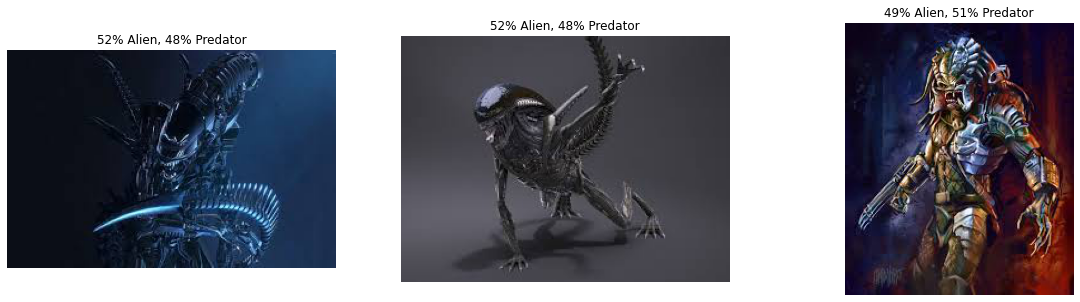

In [124]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*prediction_prob2[i,0],
                                                            100*prediction_prob2[i,1]))
    ax.imshow(img)

### 모델3(Inception v3) 예측

In [125]:
prediction_prob3 = model3.predict(validation_batch)
print(prediction_prob3)

[[0.0403191  0.95968086]
 [0.18322454 0.81677544]
 [0.17531534 0.8246846 ]]


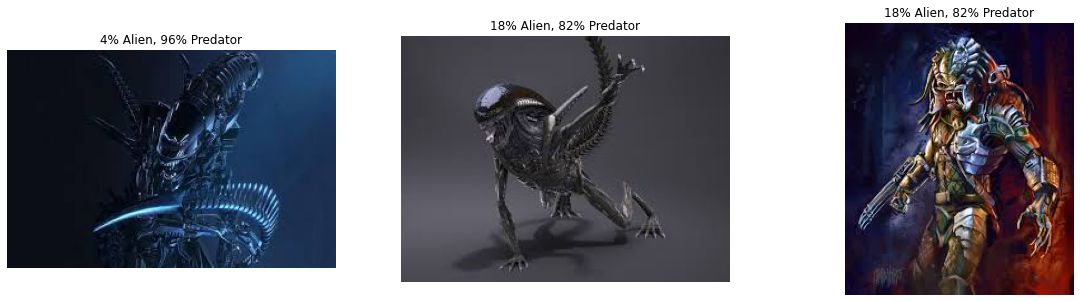

In [126]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*prediction_prob3[i,0],
                                                            100*prediction_prob3[i,1]))
    ax.imshow(img)

# 잠정 결론  
  
Alien/Predator 이미지 분류 시, res50이 다른 것들에 비해 매우 뛰어난 성능을 보인다.

## References  
[1] https://github.com/deepsense-ai/Keras-PyTorch-AvP-transfer-learning/blob/master/Keras-ResNet50.ipynb